In [1]:
import molsysmt as msm
from molsysmt import pyunitwizard as puw
import omembrane as omem
import openmm as mm
from openmm import unit as u
import numpy as np
import math
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
upper_composition={'POPC':100}
lower_composition={'POPC':100}

In [3]:
length_x, length_y = omem.build.get_membrane_size_from_composition(lower_composition, upper_composition)

In [4]:
print(length_x, length_y)

82.64381404557754 A 82.64381404557754 A


In [5]:
upper_lipid_radius = []
upper_lipid_type = []
n_upper_lipids = 0
    
for name, nn in upper_composition.items():
        
    upper_lipid_type += [name for ii in range(nn)]
    upper_lipid_radius += [omem.lipid.get_radius(name) for ii in range(nn)]
    n_upper_lipids += nn

lower_lipid_radius = []
lower_lipid_type = []
n_lower_lipids = 0
    
for name, nn in lower_composition.items():
        
    lower_lipid_type += [name for ii in range(nn)]
    lower_lipid_radius += [omem.lipid.get_radius(name) for ii in range(nn)]
    n_lower_lipids += nn

In [6]:
upper_positions = omem.build.get_initial_random_seeds_leaf(upper_lipid_radius, length_x, length_y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.55it/s]


In [7]:
lower_positions = omem.build.get_initial_random_seeds_leaf(lower_lipid_radius, length_x, length_y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.47it/s]


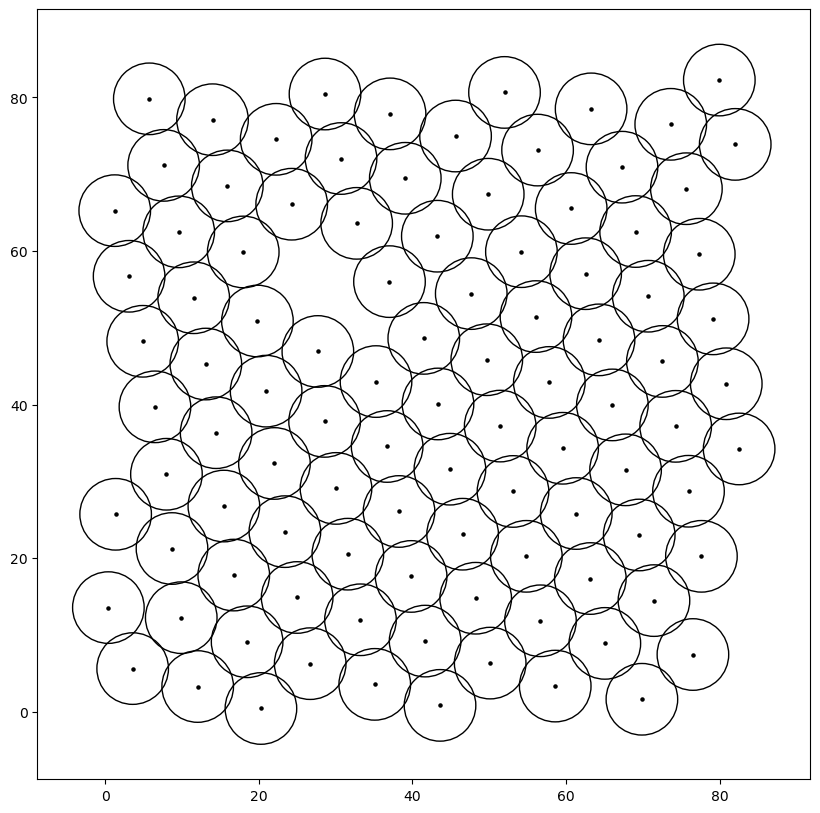

In [8]:
plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_upper_lipids):
    ax.add_patch(plt.Circle(10.0*upper_positions[ii,:]._value, radius= upper_lipid_radius[ii]._value, color='k', fill=False))

plt.scatter(10.0*upper_positions[:,0]._value, 10.0*upper_positions[:,1]._value, s=5, c='k')

plt.axis('scaled')

plt.show()

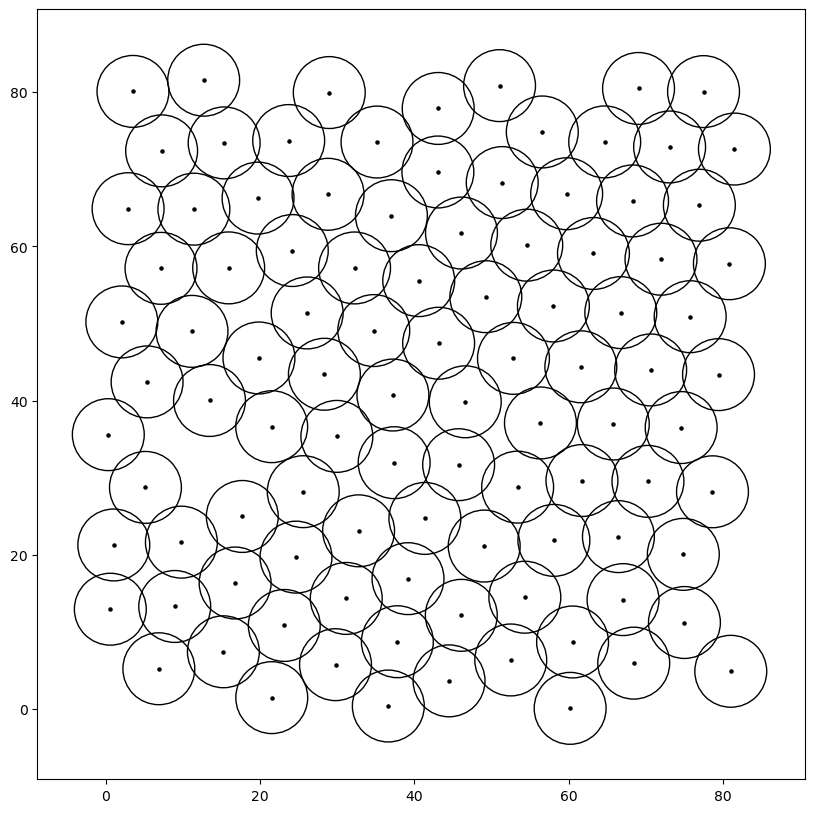

In [9]:
plt.rcParams["figure.figsize"] = (10,10)

ax=plt.gca()
for ii in range(n_lower_lipids):
    ax.add_patch(plt.Circle(10.0*lower_positions[ii,:]._value, radius= lower_lipid_radius[ii]._value, color='k', fill=False))
    
plt.scatter(10.0*lower_positions[:,0]._value, 10.0*lower_positions[:,1]._value, s=5, c='k')

plt.axis('scaled')

plt.show()

In [10]:
## Upper leaflet

lipids = omem.lipid.get_random_lipid('POPC', 100)

for ii in tqdm(range(100)):
    lipid = lipids[ii]
    position = upper_positions[ii]
    msm.structure.translate(lipid, translation=position, in_place=True)

upper_leaflet = msm.merge(lipids)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s]


In [11]:
## Lower leaflet

lipids = omem.lipid.get_random_lipid('POPC', 100)

for ii in tqdm(range(100)):
    lipid = lipids[ii]
    position = lower_positions[ii]
    msm.structure.translate(lipid, translation=position, in_place=True)
    
lower_leaflet = msm.merge(lipids)
msm.structure.flip(lower_leaflet, in_place=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]


In [12]:
allowed = 50

bins_edges, frequency = omem.analysis.get_lineal_density(upper_leaflet, selection = 'all', axis = [0,0,1],
                                                       bin_length = '0.1 nm', frequency=True)

atoms_in = 0
for inf_lim, n_atoms in zip(bins_edges[:-1], frequency):
    atoms_in += n_atoms
    if atoms_in>allowed:
        break

translation = puw.quantity(np.zeros((3)), 'nm')
translation[2] = -inf_lim

print(inf_lim, atoms_in)

msm.structure.translate(upper_leaflet, translation=translation, in_place=True)

bins_edges, frequency = omem.analysis.get_lineal_density(lower_leaflet, selection = 'all', axis = [0,0,1],
                                                       bin_length = '0.1 nm', frequency=True)
atoms_in = 0
for inf_sup, n_atoms in zip(reversed(bins_edges[1:]), reversed(frequency)):
    atoms_in += n_atoms
    if atoms_in>allowed:
        break

translation[2] = -inf_sup

print(inf_sup, atoms_in)

msm.structure.translate(lower_leaflet, translation=translation, in_place=True)

-2.1497630296225427 nanometer 129.0
2.1320163031095754 nanometer 124.0


In [13]:
membrane = msm.merge([upper_leaflet, lower_leaflet])

In [14]:
msm.view(membrane)

NGLWidget()

In [26]:
bins_edges, density_P = omem.analysis.get_lineal_density(membrane, selection = 'atom_name == "P"', axis = [0,0,1],
                                                       bins = 80, range="[-3.5, 3.5] nm")

bins_edges, density_Any = omem.analysis.get_lineal_density(membrane, selection='all', axis = [0,0,1],
                                                       bins = 80, range="[-3.5, 3.5] nm")

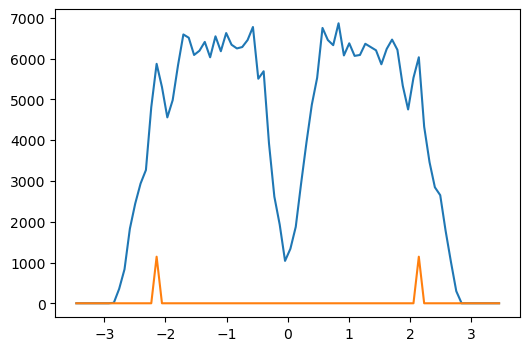

In [29]:
plt.rcParams["figure.figsize"] = (6,4)
plt.plot((bins_edges[1:]+bins_edges[:-1])/2, density_Any)
plt.plot((bins_edges[1:]+bins_edges[:-1])/2, density_P)
plt.show()

In [30]:
clearance = puw.quantity(3, 'nm')